# User Experience Concept for Specutils fitting 

Created May 2018

This is an example user workflow showing the plan for a typical line-fitting operation for a user.

Note: this is *not* scoped to be "all line fitting for everyone".  Plenty of astronomers have strong opinions about various parts of this process and probably want to do their own thing.  The goal here is to provide pieces that users can use to produce their own workflows in that case.

##  Preliminaries

This illustrates how one might get the data - the first case demonstrates a hypothetical spectrum from NIRSpec/etc from JWST.  The second is a more generic "I'm loading my data from a file" case.

In [ ]:
import specutils

In [ ]:
# if you have jwst data

import jwsttools #NEEDS IMPLEMENTING

program_data = jwsttools.download_program(pid=1234)
spectral_collection = program_data.spectra
spectra = spectral_collection.as_list()  

Note re: the above: `SpectralCollection` doesn't yet exit... it might be it can be treated as a list in the end. But the point is that `spectra` should act like a list of `Spectrum1D` objects in the end to match the below cell.

In [ ]:
# if you are from some random telescope that gave you any of the formats specutils can read
from glob import glob

fns = glob('my_awesome_spectra_*.fits')
spectra = [specutils.Spectrum1D.read(fn) for fn in fns]

## One spectrum vs many

In most cases the user will be thinking about one spectrum.  They might do on as an example, and then apply the algorithms repeatedly (that's the case considered at the end of this notebook).  Others may wish to repeat these steps individually or in part for *every* spectrum in their dataset. In principal, `SpectrumCollection` will enable at least some of these steps.  For the sake of clarity, though (and simplicity in initial implementation), here we consider the "one spectrum" case, on the theory that the rest is either a for-loop or many copy-and-pasted cells.

In [ ]:
spectrum = spectra[0]  # spectrum is now a specutils.Spectrum1D object

## Viewing the spectrum

Some sort of view of the spectrum is critical. Below we consider the "easy" and "fancy" versions: the rest of the notebook will mostly assume the former, but the idea is that some/all of the steps that require interaction could be automated in the "fancy" version.

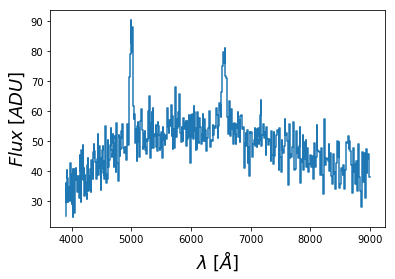

In [10]:
import specviz


# This *might* belong in specutils, possibly even spectrum.plot() although that requires some discussion/decision
specviz.plot_spectrum(spectrum)  

OR

In [1]:
specviz.show(spectrum)

A FANCY NOTEBOOK-BASED SPECVIZ GUI GOES HERE!


The GUI above could include most of the Qt specviz features, but in this view would be limited to interactive viewing/rescaling, and selection of ROIs.  

## Step "0": continuum fitting

Some spectra come out of their reduction pipeline continuum-subtracted, or the continuum might be so low that it's effectively missing.  In those cases this step isn't necessary.  In other cases, they come out of the pipeline flux calibrated (e.g., for HST spectra). In that case, for some science cases the user has their own continuum model that they construct and subtract from the spectrum (not addressed here, but allowing this step to be skipped). In yet other cases users want their model to *include* the continuum in some manner or another, leading to skipping the second part of this step.

But assuming they *do* need to deal with the continuum, the first step is to create a model.  Specutils should include a "reasonable" continuum fitter that "just works" for some fairly typical use cases (e.g. optical spectra of stars or emission line galaxies).  The trouble is that the definition of "typical use cases" really depends on the setting.  So we will evetnually have a class of `fit_continuum_*` functions that do something sensible. But we can start with something in that vein that seems to work for some cases, along the lines of:

In [ ]:
continuum_model = specutils.fit_continuum_generic(spectrum)

These are by design going to be a bit "magical", though.  So the user should also be able to just choose a reasonable continuum model and a fitter.  E.g.,

In [ ]:
continuum_model = specutils.fit_continuum(spectrum, model=Chebyshev1D(10), fitter=LinearLSQFitter())

This is by design a very limited function that just does the fitting, perhaps some uncertainty-related operations (in the future) and perhaps some unit-related transforms. The expectation is that the `fit_continuum_*` functions typically call `fit_continuum` as their *final* step.  

But some users of `fit_continuum` will want to do "pre-steps" because they want to have control like what they might expect from the [IRAF continuum task](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?continuum).  As an example, users might expect also to be able to average points together as part of continuum fitting. We should tell them they can do that as a separate smoothing/decimation step if that's what they want:

In [ ]:
averaged_spectrum = specutils.box_smooth(spectrum, 3)[::3]
continuum_model = specutils.fit_continuum(averaged_spectrum)

As more `fit_continuum_*` functions appear, that may become less necessary, but it should always be possible for a user to "take full control" that way if they want.

Additionally, for some spectra (like the one above), there might be spectral lines that "infect" the continuum measurements.  Users will want to be able to specify regions of the spectrum to be either fit or excluded from the fit.

The actual selection of ROI's could be done using a specviz-style GUI.  Something like:

In [12]:
viz = specviz.show(spectrum)

A FANCY NOTEBOOK-BASED SPECVIZ GUI GOES HERE
The user uses that GUI to select a few areas they want to exclude from the continuum fit.


In [15]:
to_exclude = viz.get_selections()
to_exclude

[<Quantity [ 4900., 5100.] Angstrom>, <Quantity [ 6400., 6600.] Angstrom>]

Or absent a GUI the user can simply specify the ranges manually:

In [ ]:
to_exclude = [(4900, 5100)*u.angstrom, (6400, 6600)*u.angstrom]

For other tools like the analysis tasks, it's necessary to have an understood way to describe "regions". We can use the same machinery to implement convenience functions that "slice out" parts of spectrum:

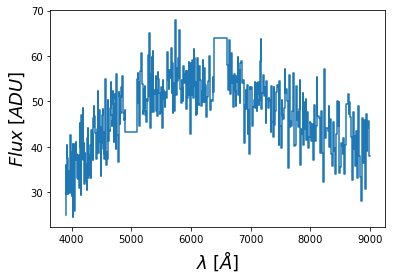

In [18]:
exclude_region = SpectrumRegion(to_exclude)
excised_spectrum = exclude_region.excise_regions(spectrum)
specviz.plot_spectrum(excised_spectrum)

And the user can then just use that for their continuum fit:

In [ ]:
continuum_model = specutils.fit_continuum_generic(excised_spectrum)

That then yields the users' continuum model.

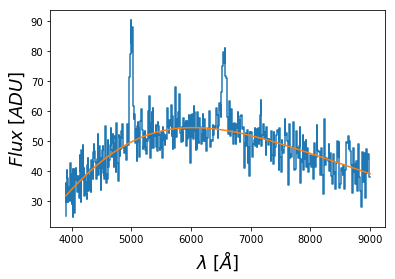

In [11]:
specviz.plot_spectrum(spectrum)
plt.plot(spectrum.spectral_axis, continuum_model(spectrumXXX))

Now that there's a model, the user can do subtraction, normalization, or just hold onto the model for later.

In [ ]:
# This `model_to_spectrum` function is pretty straightforward to implement -
# - probably just a few lines, which means it's debatable if it's worth writing.
# but it's probably worth it because it's probably needed in several places.
continuum_spectrum = specutils.model_to_spectrum(continuum_model, spectrum.spectral_axis) 

# because the continuum_spectrum is Spectrum1D, it's trivial arithmetic operations
spectrum_consub = spectrum - continuum_spectrum
spectrum_connorm = spectrum/continuum_spectrum

The end result is a `Spectrum1D` that has been either:

1. Unaltered 
2. Continuum-subtracted
3. Continuum-normalized

The steps below should accept all these cases, although not necessarily equally well.

## Step 1: Identify Lines

The user should be able to ask both if there's a line in a particular spot or spots:

In [5]:
wl0 = 656.3*u.nm
is_there_a_line_there(spec, wl0)  #needs a better name...

True

In [6]:
is_there_a_line_there(spec, 6200*u.AA) 

False

In [9]:
is_there_a_line_there(spec, [5007, 6200, 6563]*u.AA)

array([ True, False,  True])

rafds

Optional: a ``z`` parameter.  This would be for galaxies that are redshifted where you want to pass in a line list and ask how many actually match.  But would could argue that the redshift state should be on the spectrum instead, or the line list should be shiftable, or similar:

In [10]:
# if the spectrum is of a galaxy actually at reshift 0.2 this would work:
is_there_a_line_there(spec, [5007, 6563]*u.AA, z=0.2)

array([ True,  True])

The user should also be able to ask "give me all the lines":

In [4]:
wls = find_lines(spec, threshold=3) # threshold might be S/N? Something like that, anyway
wls

<Quantity [5006.98123414, 6563.14542   ] Angstrom>

In [7]:
# this should *always* be true - that is the user can expect the functions give consistent answers
all([is_there_a_line_there(spec, wl) for wl in wls])

True

Alternative: have these functions return the "guess" models instead of booleans/wl lists.  I think the above is better because it can be done very heuristically using e.g. flux vs S/N and a threshold. Or there could even be *both* options: e.g. `find_lines` and `find_model_lines`, where the former uses the `analysis` functions and the latter users the model-guessing stuff.

## Interlude: Simple Measurements

Some users won't need to do full spectrum fitting.  Instead they might want to do simpler statistics like equivalent width, FWHM, etc. They should be able to start from this point as long as they specify the window for measurement:

In [ ]:
from specutils.anlaysis import equivalent_width, fwhm

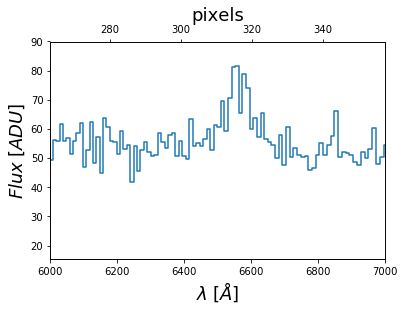

In [17]:
specviz.plot_spectrum(spectrum, 6000*u.angstrom, 7000*u.angstrom)

In [19]:
region1 = (6400*u.angstrom, 6600*u.angstrom)
fwhm(spectrum_consub, region1)

<Quantity 50.0 Angstrom>

In [ ]:
def signal_to_noise(spec, regs):
    x1, x2 = reg.to_pixels(spec)
    x1, x2 = spec.to_pixels(reg)
    return np.sum(spec.data[x1:x2] / spec.uncertainty.to_std()[x1:x2])

    for reg in regs:
        subspec = spec.get_region(reg)
        result.append( np.sum(subspec.flux) / std ) )
    
    
... inside Spectrum1D ...
def region_to_pixels(self, reg):
    ...
    ...
    return self.wcs.world_to_pix(ref[0]), self.wcs.world_to_pix(ref[0]) 

def excise_spectrum(self, reg):
    x1, x2 = self.region_to_pixels(reg)
    x1 = int(np.ceil(x1))
    x2 = int(np.floor(x2))
    
    return self[x1:x2]

def flux(spec, reg):
    return np.sum(spec.excise_spectrum(reg).flux)
    

def flux(spec, reg):
    x1, x2 = self.region_to_pixels(reg)
    center_flux = np.sum(spec.excise_spectrum(reg).flux)
    wl1 = self.wcs.pix_to_world(x1)
    wl2 = self.wcs.pix_to_world(np.ceil(x1))
    wl3 = self.wcs.pix_to_world(np.floor(x1))
    left side = flux_in_that_one_pixel[x1] * (wl2-wl1)/(wl3-wl2)
    right_side = ...
    return center_flux + left_side + right_side

In [21]:
fwhm(spectrum_consub, region1, u.pixel)

<Quantity 5.0 pix>

In [20]:
region2 = SpectrumRegion(310*u.pixel, 330*u.pixel)
equivalent_width(spectrum_consub, region2)

<Quantity 20.0 Angstrom>

In [22]:
equivalent_width(spectrum_consub, region2, u.pixel)

ValueError: equivalent width does not make sense with pixels

## Step 2: Line Guesses

The basic version starts from step 1 and asks for the best guess model:

In [14]:
guess_line(spec, wl0, Gaussian1D)

<Gaussian1D(amplitude=28.1231, mean=6562.1231, stddev=40.23)>

This should also work for Lorentz profiles since it's the same idea and the parameters only differ in that its FWHM instead of sigma:

In [21]:
guess_line(spec, wl0, Lorentz1D)

<Lorentz1D(amplitude=28.1234, x_0=6562.1231, fwhm=102.5865)>

And Voigt profiles (which can get equal halves of each amplitude - see https://doi.org/10.1016/0022-4073(77)90161-3 for derivation of some of the magic numbers  to make e.g. fwhm's match - fwhm_full = 1.6375959202100432 fwhm_each.)

In [66]:
guess_line(spec, wl0, Voigt1D)

<Voigt1D(x_0=6562.1231, amplitude_L=39.8406783, fwhm_L=62.64457473, fwhm_G=62.64457473)>

Option: Have these return "False" or similar if there's not a significant enough line.  That would be the `find_mdoel_lines` from the "Alternative" of step 1 in a way that doesn't require a separate function.

## Step 3: Fit Lines

At this point most of the "real" work has been done.  The final step is to actually do the line fitting. For line-fitting, there's actually two broad categories of approaches users are likely to want, which require somewhat different interfaces, so we will address them separately.

### Approach 1: Separately fit each line

The more traditional approach is to fit individual lines (and the region just around them) of a continuum-subtracted image. A single convenience function can do this given that the complexity of defining the models to fit has been dealt with above:

In [ ]:
fitted_lines = specutils.fit_lines(spectrum_consub, guess_models)

The default parameters should be reasonable enough that this yields a list of line models matching the `guess_models`, but fitted to the spectrum.

There are several options that should be available, though:

In [ ]:
fitted_lines = specutils.fit_lines(spectrum_consub, guess_models,
                                   fitter=LinearLSQFitter(),
                                   window='3-std',
                                   weights=None)

The `fitter` is simply the object that is used to fit the models to the data, a standard astropy fitter.

The `window` keyword specifies the region to be cut-out surrounding the lines. This can be either an array or a scalar - in the array case it has to have a length that matches the models, and is a way to give a specific cut-out for *every* line.  The scalar case is for all-the-same.  In either the array or scalar case, the window should be possible to be specified in 4 different forms.

* `'X-std'`: this means use X times the `std` parameter of the initial model (it could be *any* parameter name, but only that one really makes sense for a Gaussian).  That is, use the guesses from Step 2.  Note that this is a bit non-ideal because we would want it to just be something simple like 3sigma, and *not* have to have it be customized for different models.  Solving that could be done in the next round, though.

In [ ]:
fitted_lines = specutils.fit_lines(spectrum_consub, guess_models,
                                   window='3-std')

* raw number (or Quantity with units of pixel): this means use a window that many pixels wide. 

In [ ]:
# assume that the narrow_line/wide_line are taken from the guesses above
fitted_lines = specutils.fit_lines(spectrum_consub, [narrow_line, wide_line],
                                   fitter=LinearLSQFitter(),
                                   window=[10, 30])

* Quantity with units that match the `spectral_axis`: this means use a window that covers that range of the line.

In [ ]:
fitted_lines = specutils.fit_lines(spectrum_consub, guess_models,
                                   window=20*u.angstrom)

* `SpectralRegion` objects - this specifies an exact set of regions to give the user full control.

In [ ]:
# Same as the above, but use SpectrumRegion objects to set the window
window1 = SpectrumRegion(100*u.pixel, 200*u.pixel)
window2 = SpectrumRegion(6400*u.angstrom, 6600*u.angstrom)
fitted_lines = specutils.fit_lines(spectrum_consub, [narrow_line, wide_line],
                                   fitter=LinearLSQFitter(),
                                   window=[window1, window2])

The `weights` keyword is a weighting term to include.  Note also that this is *multiplied by* the mask in the spectrum.  It does *not* override the mask.  This needs to be stated very clearly in the docstring.


For the first cut it can either be an None(the examples above), meaning no weighting, or alternatively an array of weights or a special string like `'ivar'`, as per below:

In [ ]:
weights = np.ones(len(sspectrum_contsub))
weights = sspectrum_contsub.flux < -10*u.adu  # say we know for some reason that extreme-negative values are bad

fitted_lines = specutils.fit_lines(spectrum_consub, guess_models,
                                   weights=weights)

In [ ]:
fitted_lines = specutils.fit_lines(spectrum_consub, guess_models,
                                   weights='ivar')

In the `ivar` case it uses the inverse-variance (or raises an error if there's no uncertainty).  In the future more uncertaintainty-related options may be included.

Note that the `fit_lines` function is expected to use much of the same machinery as `fit_continuum`, since it's essentially the same operation, just inside a for loop for the many-models case.  But that's hidden from the user because of the different "pre-steps" required for line-fitting.

### Approach 2: combined fit of all the components

Another approach that has gained popularity of late due to improved computation and stellar models, is the "full spectrum fitting" or "forward-modeling" approach.  In this case the model is esentially a generative model of the full spectrum, and all of that is fit simultaneously.  Although Step 0-2 are largely the same, the fitting process is implemented quite differently, so it is logical to give it a distinct function, although it looks quite similar to the above approach.

Here the user has to combine all the above models to get a single model to fit:

In [ ]:
combined_model0 = specutils.combine_models([continuum_model] + guess_models)

There are many possible keywords for the above function that we might want to add later, but for a first cut, it should *only* do the above, which is to create a composite model that is the sum of all the individual models.

Then the final fit is actually quite simple, re-using the `fitter` and `weights` arguments from Approach 1. (Note that probably this should use the same *underlying* function to ensure they act the same, but that's an implementation detail)

In [ ]:
combined_model, fitted_cont_and_lines = specutils.fit_full_spectrum(spectrum_consub, combined_model0,
                                   fitter=LinearLSQFitter(),
                                   weights=None)

One critical difference from the above though: this returns both a single combined model *and* the individual models.  This is possible with the `astropy.modeling` machinery, but can be rather confusing.  So this provides an easier interface that automatically does it.

Utilizing either approach, the user should now be able to plot up the combined fits:

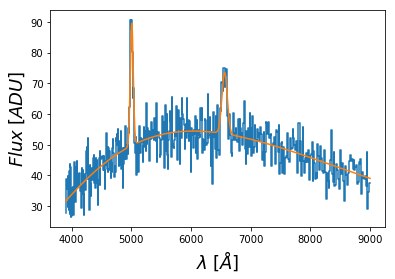

In [6]:
specviz.plot_spectrum(spectrum, combined_model)

## Step n: Wash, Rinse, and Repeat

## Unanswered Questions

* As outlined above, there is no understanding of what *kind* of `spectral_axis` a continuum or line fit model should correspond to.  One option would be to use the modeling unit machinery to force it to only be a specific unit, but that *might* be a lot of work (perhaps someone should try it?).  Alternatively, the models could just get an additional attribute `spectral_axis_type` that the user has to know to look for in their own custom code, but at least the `specutils` operations can catch if something doesn't match.

# Miscellaneous stuff (not part of the interface document)

Below here is code to "fake" the plots above, etc.  Not a part of the actual document.

In [1]:
import numpy as np

from astropy import units as u
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM

%matplotlib inline
from matplotlib import pyplot as plt

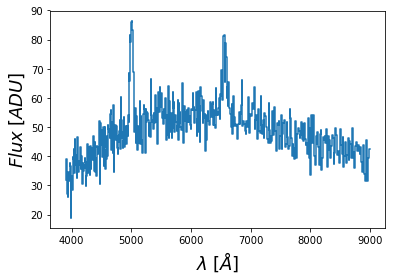

In [2]:
fake_spectrum_x = np.logspace(np.log10(3900), np.log10(9000), 512)*u.angstrom
continuum_spectrum = 500000*models.BlackBody1D(temperature=4800*u.K)(fake_spectrum_x).to(FLAM, u.spectral_density(fake_spectrum_x)).value
fake_spectrum_noiseless = continuum_spectrum + models.Gaussian1D(20,6563, 45)(fake_spectrum_x.value)
fake_spectrum_noiseless += models.Gaussian1D(40,5007, 25)(fake_spectrum_x.value)
fake_spectrum = fake_spectrum_noiseless + 5*np.random.randn(len(fake_spectrum_x))

plt.step(fake_spectrum_x, fake_spectrum)
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18);

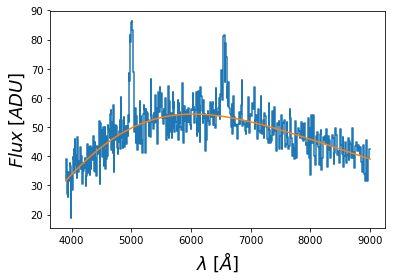

In [3]:
plt.step(fake_spectrum_x, fake_spectrum)
plt.plot(fake_spectrum_x, continuum_spectrum)
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18);

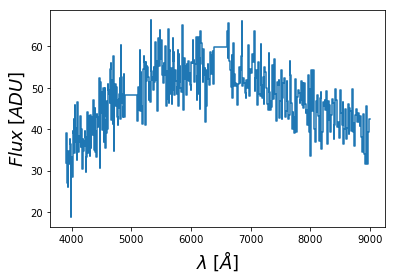

In [4]:
to_exclude = [(4900, 5100)*u.angstrom, (6400, 6600)*u.angstrom]

msk = (~((4900<fake_spectrum_x.value)&(fake_spectrum_x.value<5100))&
       ~((6400<fake_spectrum_x.value)&(fake_spectrum_x.value<6600)))

plt.step(fake_spectrum_x[msk], fake_spectrum[msk])
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18);

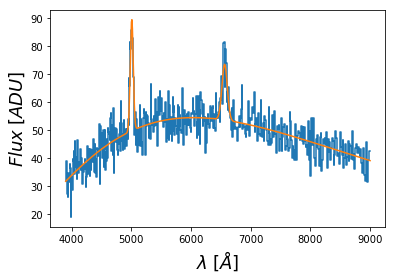

In [5]:
plt.step(fake_spectrum_x, fake_spectrum)
plt.plot(fake_spectrum_x, fake_spectrum_noiseless)
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18);

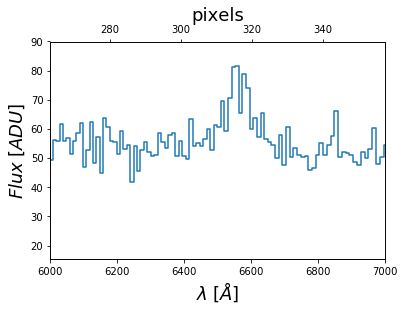

In [17]:
plt.step(fake_spectrum_x, fake_spectrum)
plt.xlim(6000, 7000)
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18)
plt.twiny()
plt.xlim(np.interp(6000, fake_spectrum_x, np.arange(len(fake_spectrum_x))), np.interp(7000, fake_spectrum_x, np.arange(len(fake_spectrum_x))))
plt.xlabel('pixels', fontsize=18);